# Simulate Data for Paper

We'd like to simulate some data for the paper, based on the `simulator` in Stingray, so let's do that!

In [1]:
%matplotlib notebook
from stingray import Lightcurve, sampledata

import numpy as np
from scipy import signal
from matplotlib import pyplot as plt
try: 
    import seaborn as sns
    sns.set_style("whitegrid")
    sns.set_context("talk")
    sns.set_palette("colorblind")
except ImportError:
    print("Seaborn not installed. Oh well.")


data_colour = "black"
model_colour = "red"

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:18: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


## Simulate a Simple Power spectrum

We are going to simulate a power spectrum with a simple power law and a broad QPO at higher frequencies.

In [28]:
from astropy.modeling import models

In [29]:
m = models.PowerLaw1D() + models.Lorentz1D()

Let's set the parameters:

In [30]:
m.x_0_0.fixed = True

In [31]:
m.amplitude_0 = 0.1
m.alpha_0 = 1.0
m.amplitude_1 = 1.0
m.x_0_1 = 2.0
m.fwhm_1 = 1.0


In [32]:
m.parameters

array([ 0.1,  1. ,  1. ,  1. ,  2. ,  1. ])

In [33]:
tseg = 256*60

In [34]:
freq = np.linspace(1.0/tseg, 10.0, 10*tseg)

In [35]:
spec = m(freq)

<IPython.core.display.Javascript object>


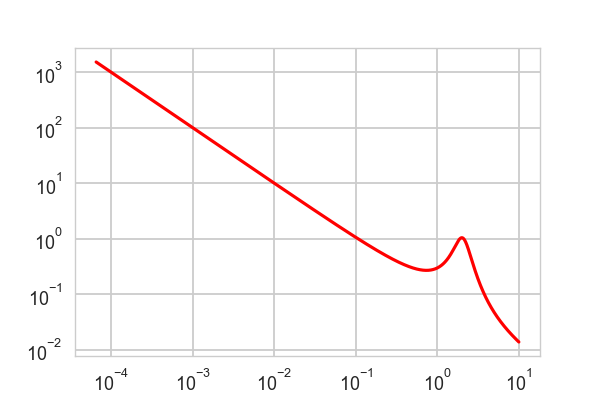

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(freq, spec, color=model_colour)

In [37]:
from stingray.simulator import simulator, models

In [66]:
sim = simulator.Simulator(N=20*tseg, mean=20.0, dt=0.5/10.0, rms=0.3, random_state=100)

In [78]:
20/(0.5/10)

400.0

In [67]:
lc = sim.simulate(spec)

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:51: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [68]:
lc.dt

0.05

In [69]:
lc.tseg

15360.0

In [70]:
lc.n

307200

In [71]:
counts = np.random.poisson(lc.counts)

In [72]:
counts

array([22, 10, 15, ..., 15, 15, 17])

In [73]:
lc = Lightcurve(lc.time, counts=counts)

<IPython.core.display.Javascript object>


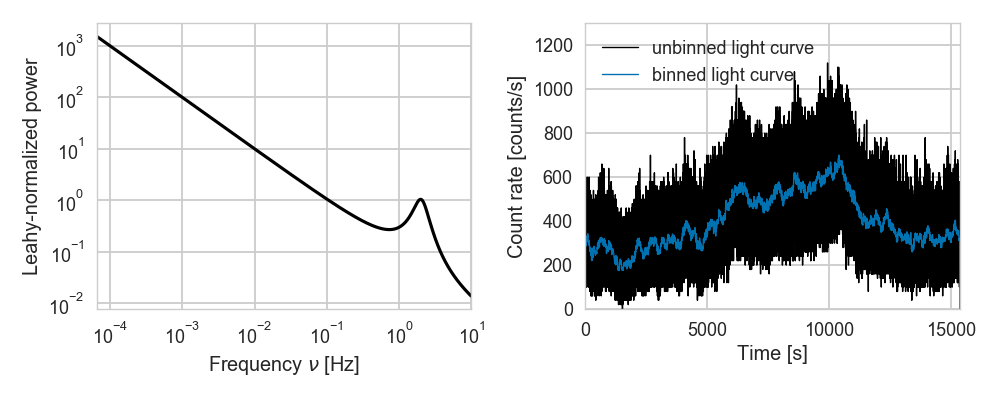

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.loglog(freq, spec, color=data_colour)
ax1.set_xlabel(r"Frequency $\nu$ [Hz]")
ax1.set_ylabel("Leahy-normalized power")
ax1.set_xlim(freq[0], freq[-1])


ax2.plot(lc.time, lc.countrate, color=data_colour, 
         linewidth=1, label="unbinned light curve")
lcbin = lc.rebin(5.0)
ax2.plot(lcbin.time, lcbin.countrate, lw=1,
             label="binned light curve")
ax2.set_xlim(lcbin.time[0], lcbin.time[-2])
ax2.set_ylim(0, 1300)
ax2.legend()
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Count rate [counts/s]")

plt.tight_layout()
plt.savefig("../figures/lc.png", format="png")

We can also include GTIs:

In [ ]:
gtis = [(0, 2000), (3000, lc.time[-1])]

In [ ]:
lc.gti = gtis

In [ ]:
lcs = lc.split_by_gti()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for l in lcs:
    ax.plot(l.time, l.countrate, color=data_colour, linewidth=1)

ax.set_xlim(lcs[0].time[0], lcs[-1].time[-1])

Let's make a power spectrum out of the light curve (without GTIs, because I can't make a single power spectrum out of an observation that has non-contiguous GTIs):

In [ ]:
from stingray import Powerspectrum

In [ ]:
lc.gti = np.array([[lc.time[0], lc.time[-1]]])

In [ ]:
ps = Powerspectrum(lc, norm="leahy", gti=None)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, linestyle="steps-mid", lw=1, color=data_colour)
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_ylim(1e-5, 1e5)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")

plt.tight_layout()

Let's rebin this so we can see the QPO. We're going to try both geometric rebinning and logarithmic rebinning:

In [ ]:
ps_rebin = ps.rebin(df=0.001)
ps_log_rebin = ps.rebin_log()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, linestyle="steps-mid", color=data_colour, 
         linewidth=1, alpha=0.5, label="Unbinned power spectrum")
ax.loglog(ps_rebin.freq, ps_rebin.power, linestyle="steps-mid", color=sns.color_palette()[0],
         linewidth=2, alpha=1.0, label="Linearly rebinned power spectrum")
ax.loglog(ps_log_rebin.freq, ps_log_rebin.power, linestyle="steps-mid", color=sns.color_palette()[2],
         linewidth=2, alpha=0.8, label="logarithmically rebinned power spectrum")

ax.set_xlim(ps_rebin.freq[1], ps_rebin.freq[-1])
ax.set_ylim(1e-5, 1000)
ax.legend(loc=1, prop={"size":11})
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()


Let's make an averaged powerspectrum so that the QPO is visible:

In [ ]:
from stingray import AveragedPowerspectrum

In [ ]:
aps = AveragedPowerspectrum(lc, segment_size=256.0)

We can also rebin this version for a much clearer view:

In [ ]:
aps_binned = aps.rebin_log()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o", markersize=3, 
            color=data_colour, lw=1, label="Averaged PSD, m=60")

ax.errorbar(aps_binned.freq, aps_binned.power, yerr=aps_binned.power_err, fmt="o", markersize=3, 
            color=sns.color_palette()[2], lw=1, label="Averaged, log-binned PSD, m=60")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

Awesome! The QPO pops out much more clearly!

### Modeling the power spectrum

We're going to write the modeling section later, but I might as well look at the modeling right now.

So let's take our model and fit it to the averaged power spectrum:

In [ ]:
from stingray.modeling import PSDLogLikelihood, PSDPosterior, PSDParEst

First, we'll have to make a `LogLikelihood` object:

In [ ]:
loglike = PSDLogLikelihood(ps.freq, ps.power, m, m=ps.m)

Let's print an example:

In [ ]:
start_pars = [0.005, 1.0, 0.2, 2.0, 1.0, 0.2]

In [ ]:
loglike(start_pars)

In [ ]:
parest = PSDParEst(ps, fitmethod='L-BFGS-B', max_post=False)

In [ ]:
res = parest.fit(loglike, start_pars)

In [ ]:
res.p_opt

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.loglog(ps.freq, ps.power, 
            markersize=3, linewidth=1, color=data_colour)
ax.plot(ps.freq, res.mfit, lw=2, color=model_colour)
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

Ok, cool. Let's also fit the averaged power spectrum:

In [ ]:
aps_parest = PSDParEst(aps, fitmethod='L-BFGS-B', max_post=False)

In [ ]:
aps_loglike = PSDLogLikelihood(aps.freq, aps.power, m, m=aps.m)

In [ ]:
aps_pars = [0.0005, 1, 0.001, 2, 1, 0.001]

In [ ]:
aps_res = aps_parest.fit(aps_loglike, aps_pars)

In [ ]:
aps_res.p_opt

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o",
            markersize=3, linewidth=1, color=data_colour, 
            label="Averaged PSD")
ax.plot(aps.freq, aps_res.mfit, lw=2, color=model_colour, zorder=10,
        label="best-fit model")
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

### Sampling

Let's also look at the sampling. For this we are going to need a Posterior object and priors.

In [ ]:
m.param_names

In [ ]:
import scipy.stats

In [ ]:
aps.freq[-1]

In [ ]:
p_amplitude_0 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))
p_amplitude_1 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))
p_amplitude_2 = lambda amplitude: scipy.stats.uniform(loc=-20, scale=40).pdf(np.log(amplitude))

p_alpha_0 = lambda alpha: scipy.stats.uniform(loc=0, scale=5).pdf(alpha)

p_x_0_1 = lambda x_0_1: scipy.stats.uniform(loc=0.0039, scale=0.0039+9.998).pdf(x_0_1)
p_fwhm_1 = lambda fwhm: scipy.stats.uniform(loc=np.log(0.01), scale=np.log(10.0)-np.log(0.01)).pdf(np.log(fwhm))

In [ ]:
prior_dict = {"amplitude_0":p_amplitude_0, "amplitude_1":p_amplitude_1,
              "amplitude_2":p_amplitude_2, "alpha_0": p_alpha_0,
              "x_0_1": p_x_0_1, "fwhm_1":p_fwhm_1}

In [ ]:
lpost = PSDPosterior(aps.freq, aps.power, m, priors=prior_dict, m=aps.m)

In [ ]:
aps_parest = PSDParEst(aps, max_post=True, fitmethod="COBYLA")

In [ ]:
aps_pars = [0.00001, 1.5, 0.002, 2.0, 1, 0.001]

In [ ]:
aps_res = aps_parest.fit(lpost, aps_pars, neg=True)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, fmt="o",
            markersize=3, linewidth=1, color=data_colour, 
            label="Averaged PSD")
ax.plot(aps.freq, aps_res.mfit, lw=2, color=model_colour, zorder=10,
        label="best-fit model")
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xscale('log')
ax.set_yscale("log")
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
ax.legend(loc=1, prop={"size":11})
plt.tight_layout()

Okay, finally, I've got a model. Let's do MCMC:

In [ ]:
sample = aps_parest.sample(lpost, aps_res.p_opt, cov=aps_res.cov,
                           nwalkers=200, burnin=100, niter=100, threads=4, )

In [ ]:
lc = sampledata.sample_data()

In [ ]:
lc.dt

Let's first plot the light curve:

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(lc.time-lc.time[0], lc.countrate, color=data_colour)
ax.set_xlim(0.0, lc.tseg)
ax.set_xlabel(r"Time in seconds since $t_{\mathrm{start}}$")
ax.set_ylabel("Count rate [counts/s]")
plt.tight_layout()

### Power spectrum

Let's make a Power spectrum:


In [ ]:
from stingray import Powerspectrum

In [ ]:
ps = Powerspectrum(lc, norm="frac")

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(ps.freq, ps.power, color=data_colour,
          linestyle="steps-mid")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(ps.freq[0], ps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

### Averaged Powerspectrum

In [ ]:
from stingray import AveragedPowerspectrum

In [ ]:
lc.tseg

The light curve is long enough that I can make about 20 segments of 128s each:

In [ ]:
aps = AveragedPowerspectrum(lc, segment_size=2*128.0)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.errorbar(aps.freq, aps.power, yerr=aps.power_err, 
           linestyle="steps-mid", color=data_colour, fmt="o", 
            markersize=4, linewidth=1)
ax.set_xscale("log")
ax.set_yscale('log')
ax.set_xlim(aps.freq[0], aps.freq[-1])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel(r"Power [$(\mathrm{rms}/\mathrm{mean})^2/\mathrm{Hz}$]")
plt.tight_layout()

### Let's make a cross spectrum

In [ ]:
from stingray import AveragedCrossspectrum

In [ ]:
cps = AveragedCrossspectrum()